### Import Libraries

In [1]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

import warnings 
warnings.filterwarnings('ignore')

C:\Users\aun16101\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.options.display.max_columns = 100

### Load Data

In [3]:
csts_data = pd.read_excel('./HH_11_18_2016.xlsx') # Houshold File - CSTS Data
land_use = pd.read_csv('./crcog/sed_2010.csv') # Land Use Data
node = gpd.read_file('./crcog/node_network/Node.shp') #Network Nodes
hfd = gpd.read_file('./crcog/node_network/Hartford.shp') # Network
taz = gpd.read_file('./crcog/zone_shapefile/Zone.shp') # Hartford TAZ

In [5]:
land_use[:2]

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.0,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.0,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN


### Plot the Shapefiles

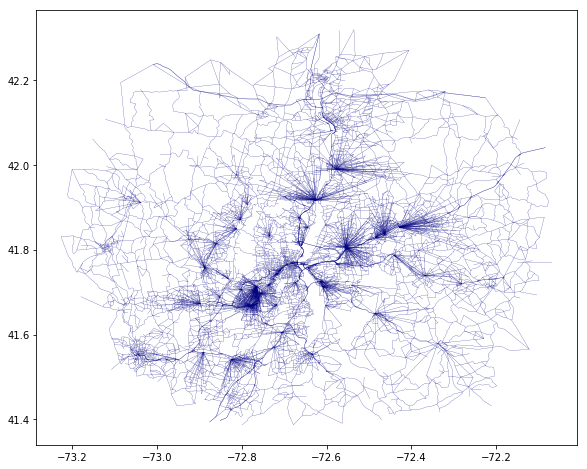

In [6]:
hfd.plot(color='navy', edgecolor='white', linewidth=.2, figsize=(12, 8))

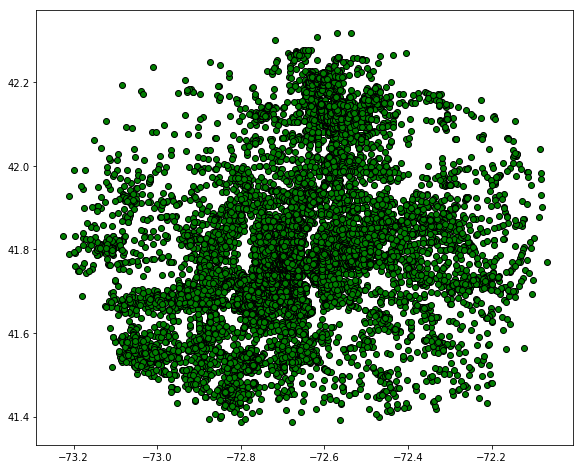

In [7]:
node.plot(color='green', edgecolor='black', figsize=(12, 8))

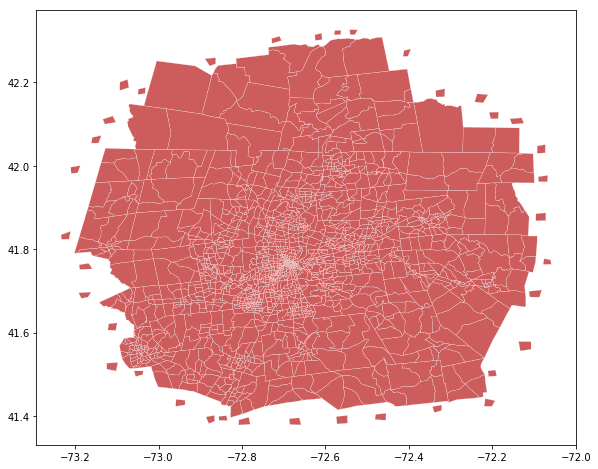

In [8]:
taz.plot(color='indianred', edgecolor='white', linewidth=.2, figsize=(12, 8))

In [9]:
taz.head()

,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ,geometry
0,1,8.27,8209,Winchester,CT,1,8.27,8209,Winchester,CT,1538,"POLYGON ((-73.168306 41.902135, -73.1651959999..."
1,2,10.68,8415,Ashford,CT,2,10.68,8415,Ashford,CT,1743,"POLYGON ((-72.151522 41.959302, -72.151645 41...."
2,3,7.08,8210,Winchester,CT,3,7.08,8210,Winchester,CT,1539,"POLYGON ((-73.12399599999999 41.913628, -73.12..."
3,4,2.89,8212,Winchester,CT,4,2.89,8212,Winchester,CT,1541,"POLYGON ((-73.06343 41.958355, -73.06389 41.95..."
4,5,7.17,8218,Barkhamstead,CT,5,7.17,8218,Barkhamstead,CT,1547,"POLYGON ((-73.04786 41.90963, -73.047838 41.90..."


In [10]:
taz['STATE'].value_counts()

CT    1721
MA      63
Name: STATE, dtype: int64

### Check Maps' Coordinate Reference System (CRS)

In [11]:
taz.crs, hfd.crs, node.crs

({}, {}, {})

In [12]:
taz.crs = {'init' :'epsg:4326'}
hfd.crs = {'init' :'epsg:4326'}
node.crs = {'init' :'epsg:4326'}

In [13]:
taz.crs, hfd.crs, node.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

### Removing external zones

In [14]:
taz = taz[taz['TAZ'] < 9000] # Removing External Zones
taz = taz[taz['STATE'] != 'MA'] # Removing Massachusetts TAZ

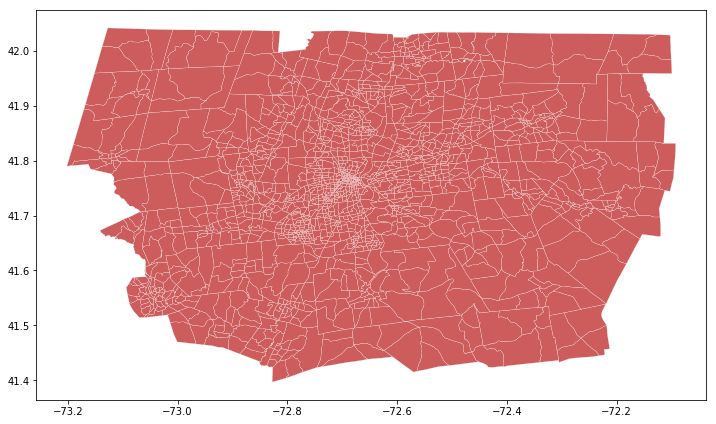

In [15]:
taz.plot(color='indianred', edgecolor='white', linewidth=.2, figsize=(12, 8))

In [16]:
taz['TAZ'].nunique()

1699

### Plot HH Locations on the Map

In [17]:
csts_data.head()

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.123930,124.747957,6,6,2,3,0,2,1,0,10,5,5
1,16100093,1,9,2016-05-18,1,3,3,0,2016-05-22 16:52:00,2016-05-22 17:05:00,13,2,2,2,3,3,3,0,0,0,0,0,0,0,1,1,3,"119 Cedar St, New Haven, CT 06519, USA",41.294890,-72.930900,New Haven County,New Haven,90091403001,4,-99,2,2,0,0,80.329024,273.042033,-99,4,2,2,0,3,2,0,8,3,3
2,16100095,6,9,2016-05-18,1,12,12,0,2016-05-14 11:26:00,2016-05-14 11:36:00,10,3,3,2,2,2,2,0,0,0,0,0,2,2,2,1,1,"2269 Durham Rd, Madison, CT 06443, USA",41.423034,-72.653383,New Haven County,Madison,90091942011,9,-99,5,1,1,0,208.123930,242.612498,-99,9,3,5,2,2,1,0,8,12,12
3,16100104,4,4,2016-04-05,1,0,0,0,2016-04-10 15:17:00,2016-04-10 15:25:00,8,2,2,0,2,2,2,0,0,0,0,0,2,2,2,2,5,"900 Falls View Rd, Manchester, CT 06042, USA",41.801384,-72.539918,Hartford County,Manchester,90035141023,99,99,99,2,0,0,161.794690,212.558437,10,10,2,5,2,2,1,0,10,0,0
4,16100112,1,3,2016-03-30,1,4,4,0,2016-03-30 13:03:00,2016-03-30 13:10:00,7,1,1,0,1,1,1,0,0,0,0,0,0,0,1,2,5,"223 Diamond St, New Haven, CT 06515, USA",41.330378,-72.948305,New Haven County,New Haven,90091414001,3,-99,1,1,0,0,80.329024,54.576913,-99,3,1,1,0,1,3,0,8,4,4


In [19]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(csts_data.home_lng, csts_data.home_lat)]
hh = GeoDataFrame(csts_data, crs=crs, geometry=geometry)
hh.head()

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode,geometry
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.123930,124.747957,6,6,2,3,0,2,1,0,10,5,5,POINT (-72.77711740000001 41.74656230000001)
1,16100093,1,9,2016-05-18,1,3,3,0,2016-05-22 16:52:00,2016-05-22 17:05:00,13,2,2,2,3,3,3,0,0,0,0,0,0,0,1,1,3,"119 Cedar St, New Haven, CT 06519, USA",41.294890,-72.930900,New Haven County,New Haven,90091403001,4,-99,2,2,0,0,80.329024,273.042033,-99,4,2,2,0,3,2,0,8,3,3,POINT (-72.93090000000001 41.29489)
2,16100095,6,9,2016-05-18,1,12,12,0,2016-05-14 11:26:00,2016-05-14 11:36:00,10,3,3,2,2,2,2,0,0,0,0,0,2,2,2,1,1,"2269 Durham Rd, Madison, CT 06443, USA",41.423034,-72.653383,New Haven County,Madison,90091942011,9,-99,5,1,1,0,208.123930,242.612498,-99,9,3,5,2,2,1,0,8,12,12,POINT (-72.65338299999996 41.423034)
3,16100104,4,4,2016-04-05,1,0,0,0,2016-04-10 15:17:00,2016-04-10 15:25:00,8,2,2,0,2,2,2,0,0,0,0,0,2,2,2,2,5,"900 Falls View Rd, Manchester, CT 06042, USA",41.801384,-72.539918,Hartford County,Manchester,90035141023,99,99,99,2,0,0,161.794690,212.558437,10,10,2,5,2,2,1,0,10,0,0,POINT (-72.53991819999999 41.8013845)
4,16100112,1,3,2016-03-30,1,4,4,0,2016-03-30 13:03:00,2016-03-30 13:10:00,7,1,1,0,1,1,1,0,0,0,0,0,0,0,1,2,5,"223 Diamond St, New Haven, CT 06515, USA",41.330378,-72.948305,New Haven County,New Haven,90091414001,3,-99,1,1,0,0,80.329024,54.576913,-99,3,1,1,0,1,3,0,8,4,4,POINT (-72.94830519999999 41.3303781)


In [20]:
hh.crs

{'init': 'epsg:4326'}

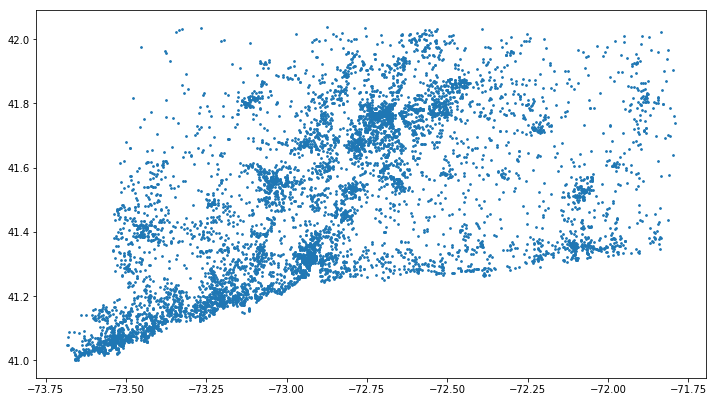

In [21]:
hh.plot(markersize=3, figsize=(12, 8))

### Select HHs within the Hartford TAZ

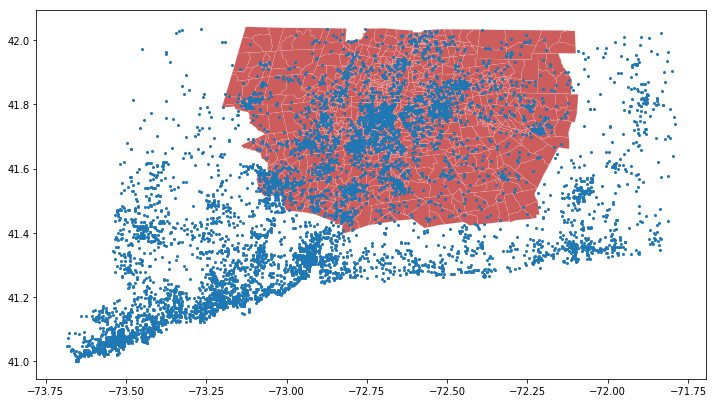

In [22]:
base = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
hh.plot(ax=base, markersize=4, figsize=(12, 8));

In [23]:
hh_in_taz = gpd.sjoin(hh, taz, how = 'inner', op = 'intersects')

In [24]:
hh_in_taz.shape

(3524, 65)

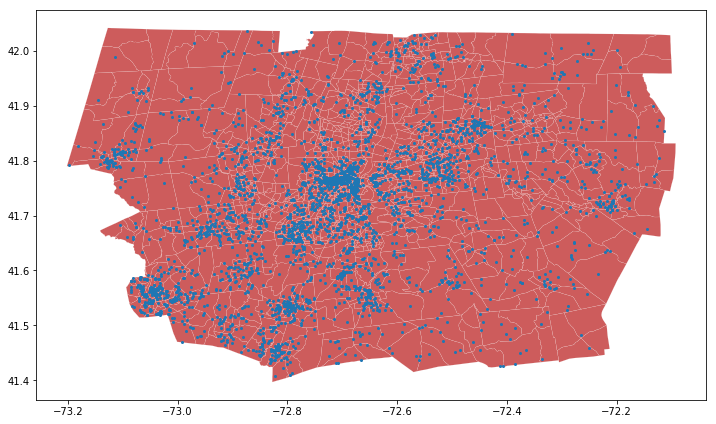

In [25]:
base = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
hh_in_taz.plot(ax=base, markersize=4, figsize=(12, 8));

### Data Preparation for Model Estimation

#### Variables in CSTS Data

In [26]:
hh_in_taz.head()

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode,geometry,index_right,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.12393,124.747957,6,6,2,3,0,2,1,0,10,5,5,POINT (-72.77711740000001 41.74656230000001),673,639,0.70,46,West Hartford,CT,639,0.70,46,West Hartford,CT,36
502,16108561,6,2,2016-03-24,1,7,7,0,2016-03-19 08:02:00,2016-03-22 09:51:00,4429,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,"10 Royal Oak Dr, West Hartford, CT 06107, USA",41.739570,-72.774538,Hartford County,West Hartford,90034966001,99,99,99,1,0,0,208.12393,89.594968,8,8,1,4,1,1,3,0,10,7,7,POINT (-72.77453800000001 41.73957),673,639,0.70,46,West Hartford,CT,639,0.70,46,West Hartford,CT,36
3,16100104,4,4,2016-04-05,1,0,0,0,2016-04-10 15:17:00,2016-04-10 15:25:00,8,2,2,0,2,2,2,0,0,0,0,0,2,2,2,2,5,"900 Falls View Rd, Manchester, CT 06042, USA",41.801384,-72.539918,Hartford County,Manchester,90035141023,99,99,99,2,0,0,161.79469,212.558437,10,10,2,5,2,2,1,0,10,0,0,POINT (-72.53991819999999 41.8013845),1327,1294,0.34,574,Manchester,CT,1294,0.34,574,Manchester,CT,477
1898,16134212,4,7,2016-05-03,1,23,20,0,2016-04-26 19:58:00,2016-04-26 20:13:00,15,2,2,0,3,3,2,1,0,1,1,1,1,1,2,2,5,"180 John Olds Dr, Manchester, CT 06042, USA",41.803214,-72.536023,Hartford County,Manchester,90035141023,8,-99,4,1,0,0,161.79469,161.751467,-99,8,2,4,1,3,1,1,10,23,20,POINT (-72.53602319999999 41.8032144),1327,1294,0.34,574,Manchester,CT,1294,0.34,574,Manchester,CT,477
2959,16153751,4,3,2016-03-31,1,11,11,0,2016-03-27 10:48:00,2016-03-27 10:58:00,10,1,1,0,2,2,2,0,0,0,0,0,0,0,1,2,5,"141 John Olds Dr #110, Manchester, CT 06042, USA",41.803209,-72.535986,Hartford County,Manchester,90035141023,99,2,2,1,0,0,161.79469,117.053577,5,5,1,2,0,2,1,0,10,11,11,POINT (-72.53598590000001 41.8032091),1327,1294,0.34,574,Manchester,CT,1294,0.34,574,Manchester,CT,477


#### Variables in Land Use Data

In [27]:
land_use.head()

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.000000,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.000000,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
2,2,9,5.454545,1.818182,0.000000,7.272727,1.818182,1.818182,0.000000,0.000000,5.454545,30.909091,0.000000,0.000000,0.000000,1.818182,1.818182,5.454545,56.363636,222,119.999999,858,45.000000,813.000000,0.000,0.000,4.000,0.000,3.000,0.018,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN
3,3,10,0.000000,0.000000,0.000000,5.471204,3.282723,1.094241,1.094241,2.188482,5.471204,56.900524,3.282723,1.094241,1.094241,0.000000,1.094241,9.848168,117.083770,573,209.000003,16,0.000000,16.333333,0.000,0.000,3.000,0.000,3.000,0.013,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN
4,4,11,0.000000,0.000000,3.517699,0.000000,7.035398,1.172566,7.035398,3.517699,1.172566,32.831858,3.517699,3.517699,0.000000,0.000000,5.862832,24.623894,171.194690,729,264.999998,332,1.767955,330.000000,0.000,0.000,6.000,0.000,4.000,0.013,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN


In [28]:
land_use['AREA_IND'].value_counts()

Non_HFD        1566
HFD Non_CBD     142
HFD CBD          52
Airport           3
Name: AREA_IND, dtype: int64

In [29]:
land_use.groupby('AREA_IND').mean()

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R
AREA_IND,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Airport,544.000000,645.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1229.000000,6.462438,1222.666667,0.00000,0.0000,20.000000,0.000000,991.000000,0.013000,0.011000,0.031000,0.044000,0.10700,0.023000,0.023000,0.056000,0.05600
HFD CBD,964.346154,2042.846154,9.070471,1.298680,1.642152,7.131446,3.193884,0.926321,1.176257,1.063710,3.423920,12.493739,0.810352,0.038262,0.090602,0.392146,0.372515,2.431478,6.559451,114.634615,52.115385,1069.846154,20.415869,1049.423625,0.00000,0.0000,1.653846,0.000000,15.038462,0.053769,0.011000,0.050000,0.024000,0.02600,0.013000,0.014000,0.018000,0.01900
HFD Non_CBD,700.507042,1356.746479,51.795641,7.151153,11.434592,34.970840,29.542826,4.674218,11.815281,6.853099,17.336697,55.398112,5.647929,1.423566,2.736590,2.495719,5.118042,16.671918,33.440818,836.197183,298.507042,375.457746,32.572573,342.892419,0.00000,0.0000,2.190141,0.000000,13.056338,0.057585,0.011000,0.050000,0.024000,0.02600,0.013000,0.014000,0.018000,0.01900
Non_HFD,895.244572,2957.441890,20.656592,3.516900,4.937851,15.317663,23.953538,6.784514,15.018660,8.834163,22.467756,87.156558,5.591325,1.790873,4.296423,3.252285,10.886174,46.576771,202.975362,1241.451469,484.013410,510.215198,87.225700,422.991451,0.00002,192.0179,8.411259,3.929139,57.065792,0.026261,0.060762,0.069319,0.038937,0.04254,0.034934,0.037561,0.043709,0.04746


In [37]:
land_use['HHSIZE'] = land_use['POPULATION']/land_use['HOUSEHOLD']

### Create NumVehicle and Income Categories to match the Land Use Data

In [30]:
hh_in_taz['numvehicle'].value_counts()

1    1319
2    1310
3     419
0     291
4     140
5      32
6       7
7       3
8       2
9       1
Name: numvehicle, dtype: int64

In [31]:
hh_in_taz['vehicle_0'] = (hh_in_taz['numvehicle'] == 0).astype(int)
hh_in_taz['vehicle_1'] = (hh_in_taz['numvehicle'] == 1).astype(int)
hh_in_taz['vehicle_2'] = (hh_in_taz['numvehicle'] >= 2).astype(int)

In [32]:
hh_in_taz['income_1'] = (hh_in_taz['imputed_hhincome_detailed'].isin([1,2])).astype(int)
hh_in_taz['income_2'] = (hh_in_taz['imputed_hhincome_detailed'].isin([3,4])).astype(int)
hh_in_taz['income_3'] = (hh_in_taz['imputed_hhincome_detailed'].isin([5,6])).astype(int)
hh_in_taz['income_4'] = (hh_in_taz['imputed_hhincome_detailed'].isin([7])).astype(int)
hh_in_taz['income_5'] = (hh_in_taz['imputed_hhincome_detailed'].isin([8])).astype(int)
hh_in_taz['income_6'] = (hh_in_taz['imputed_hhincome_detailed'].isin([9])).astype(int)
hh_in_taz['income_7'] = (hh_in_taz['imputed_hhincome_detailed'].isin([10,11,12])).astype(int)

### Linear Regression Model

In [33]:
y, X = dmatrices('hh_tripcount ~ hhsize + vehicle_0:income_1 + vehicle_0:income_2 + vehicle_0:income_3 + vehicle_1:income_1 + vehicle_1:income_2 + vehicle_2:income_1 + vehicle_2:income_2 + vehicle_2:income_6 + vehicle_2:income_7', data = hh_in_taz, return_type = 'dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           hh_tripcount   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     208.5
Date:                Thu, 16 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:47:58   Log-Likelihood:                -10451.
No. Observations:                3524   AIC:                         2.092e+04
Df Residuals:                    3513   BIC:                         2.099e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6712      0.187      8.918      0.000       1.304       2.039
hhsize                 3.0245      0.075     40.060      0.000       2.877       3.173
vehicle_0:income_1    -1.6966      0.361     -4.697      0.000      -2.405      -0.988
vehicle_0:income_2    -1.5882      0.604     -2.631      0.009      -2.772      -0.405
vehicle_0:income_3    -2.1909      0.913     -2.400      0.016      -3.981      -0.401
vehicle_1:income_1    -0.8900      0.393     -2.263      0.024      -1.661      -0.119
vehicle_1:income_2    -0.4562      0.286     -1.597      0.110      -1.016       0.104
vehicle_2:income_1    -1.4127      0.987     -1.431      0.153      -3.349       0.523
vehicle_2:income_2    -0.8523      0.496     -1.717      0.086      -1.826       0.121
vehicle_2:income_6     0.5099      0.237      2.152      0.031       0.045       0.974
vehicle_2:income_7     0.4151      0.262      1.584      0.113      -0.099       0.929
==============================================================================
Omnibus:                      783.869   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3127.352
Skew:                           1.045   Prob(JB):                         0.00
Kurtosis:                       7.115   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
coefficients = res.params.tolist()

In [36]:
coefficients

[1.6712106115904766,
 3.0245379627691986,
 -1.696582818986354,
 -1.5882390210019295,
 -2.190862257379597,
 -0.8900343845664322,
 -0.45622271306344175,
 -1.4127381072024785,
 -0.8522848021912215,
 0.5099450874390244,
 0.41511427644988436]

In [38]:
land_use[:2]

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name,HHSIZE
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.0,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN,1.775510
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.0,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN,2.109756


In [43]:
for index, row in land_use.iterrows():
    
    land_use['trip_productions'] = coefficients[0] + (row['HHSIZE'] * coefficients[1]) + (row['HH0CARINC1'] * coefficients[2]) + (row['HH0CARINC2'] * coefficients[3]) + (row['HH0CARINC3'] * coefficients[4]) + (row['HH1CARINC1'] * coefficients[5]) + (row['HH1CARINC2'] * coefficients[6]) + (row['HH2CARINC1'] * coefficients[7]) + (row['HH2CARINC2'] * coefficients[8]) + (row['HH2CARINC6'] * coefficients[9]) + (row['HH2CARINC7'] * coefficients[10])

In [44]:
land_use[:2]

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name,HHSIZE,trip_productions
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.0,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN,1.775510,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.0,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN,2.109756,NaN


In [45]:
land_use['trip_productions'].value_counts()

Series([], Name: trip_productions, dtype: int64)